# METRAP Bus Operations Analysis

Using Bus GPS traces and GTFS data

## 1. Setup and Configuration

### 1.1 Library imports and initial configurations

In [1]:
import pandas as pd
import sys
import folium
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from shapely.geometry import LineString

sys.path.append('..')  
import utils

## 2. Data Loading and Exploration

### 2.1 Load the data

In [2]:
lines_gdf = utils.load_data("./data/lines_gdf.gpkg")
gps_gdf = utils.load_gps_from_csv("./data/zg11_20250915.csv")


### 2.2 Check the loaded data on folium

In [3]:
# Create map
m = folium.Map(location=[-25.9653, 32.5832], zoom_start=11)

# Colors for lines
line_colors = [mcolors.to_hex(plt.get_cmap("turbo")(i / len(lines_gdf))) for i in range(len(lines_gdf))]

# Add all lines
for i, row in enumerate(lines_gdf.itertuples()):
    coords = [(y, x) for geom in ([row.geometry] if isinstance(row.geometry, LineString) else row.geometry.geoms) 
                        for x, y in geom.coords]
    folium.PolyLine(coords, color=line_colors[i], weight=4, opacity=0.7,
                    tooltip=row.line_id, 
                    popup=f"Line ID: {row.line_id}<br>Line Name: {row.route_label}"
                    ).add_to(m)

# Add GPS points
for idx, row in gps_gdf.iterrows():
    folium.CircleMarker(
        location=[row.lat, row.lon],
        radius=1,
        color='red',
        fillOpacity=0.7,
        popup=f"Time: {row.timestamp}<br>Speed: {row.speed_kmh} km/h<br>Direction: {row.direction}"
    ).add_to(m)

# Save
os.makedirs("./outputs", exist_ok=True)
m.save("./outputs/lines_and_gps_map.html")
print("Map saved to ./outputs/lines_and_gps_map.html")

Map saved to ./outputs/lines_and_gps_map.html


# 3. GPS Data Analysis

## 3.1 Matching GPS traces data with bus lines
Calculate distances along route and analyze GPS positioning

📍 Analyzing line L5 with 1309 GPS points
📏 Reference line length: 26.60 km

📊 Distance Statistics:
Distance along line: 0m to 26602m
Average offset from line: 271.6m
Max offset from line: 888.4m


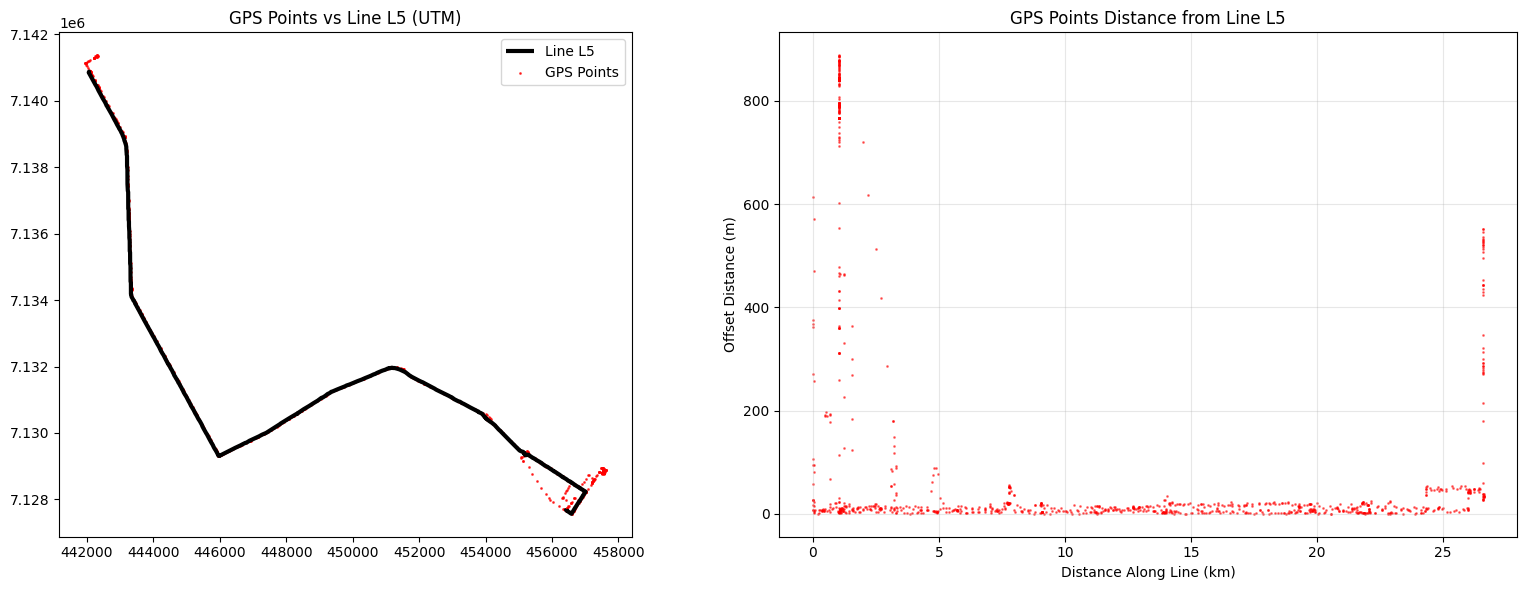

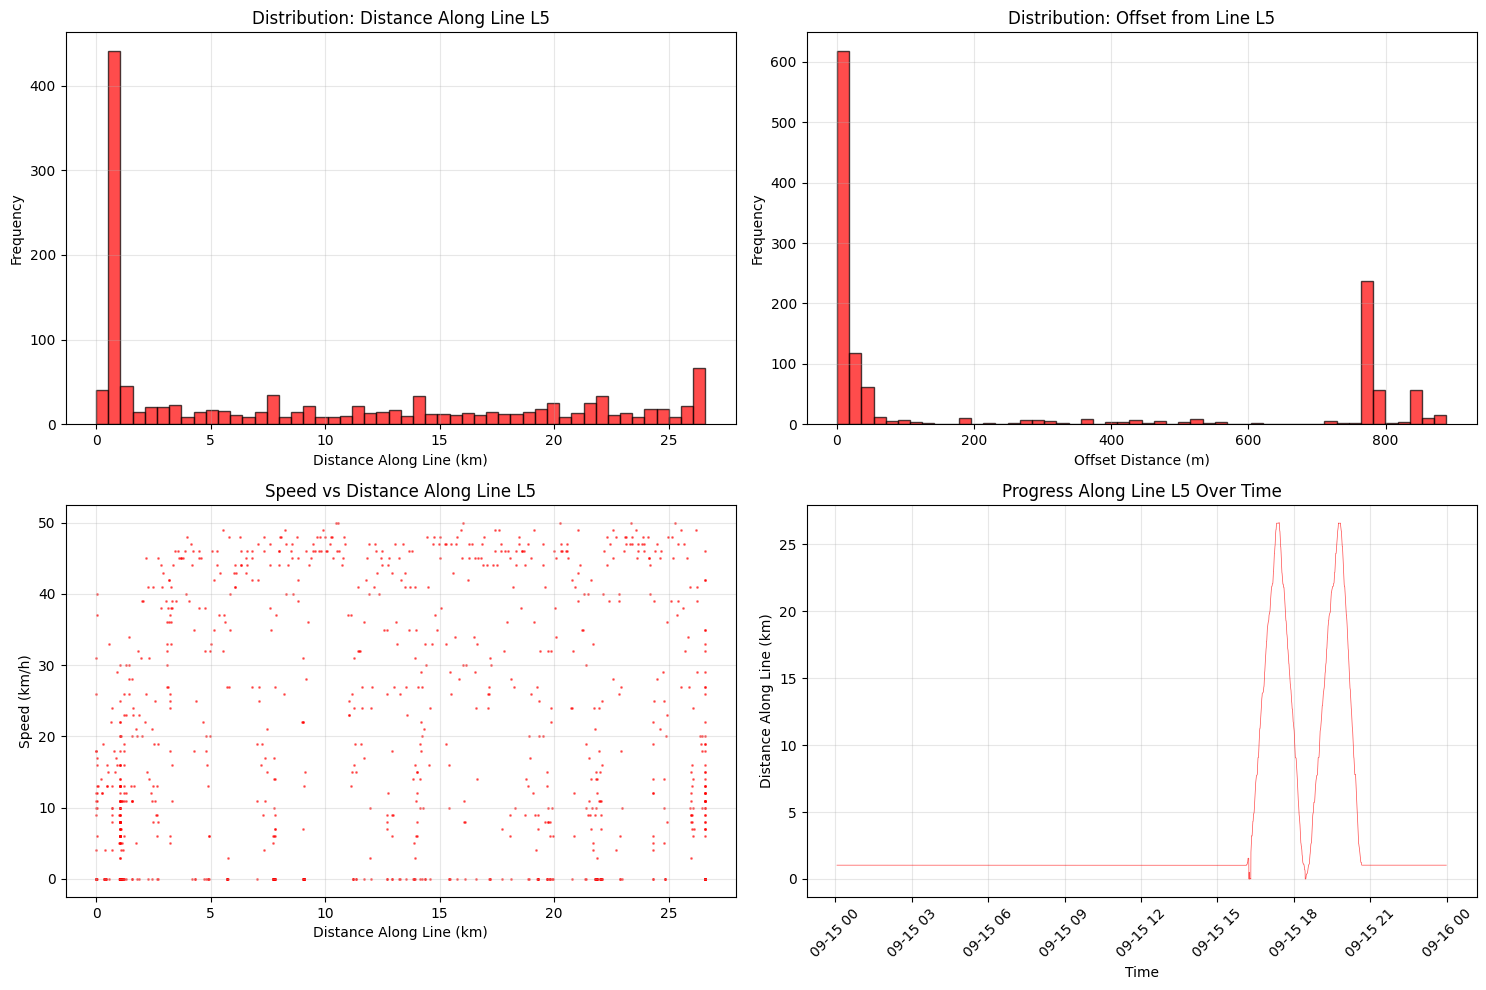

In [4]:
# Calculate distances for specific line
gps_result_gdf, ref_line = utils.calculate_line_distance(gps_gdf, lines_gdf, line_id="L5", plot=True, flip_origin=False) # Change 'L5' to other lines

# Optional: Additional analysis plots
utils.plot_distance_analysis(gps_result_gdf, line_id="L5") # Change 'L5' to other lines

## 4. Scheduled Data Processing

### 4.1 Selecting timetable dataset
Check the route_id for making scheduled_trips_gdf from here

In [5]:
# Print a list of available trips timetable for a specific line
print(utils.get_routes_for_line("L5")) # Change 'L5' to other lines

   line_id route_id  direction_id
0       L5       47             0
6       L5      47B             1
12      L5      47C             0
18      L5      47D             1
24      L5      47E             0
30      L5      47F             1


### 4.2 Checking and matching the timetable based on the route_id

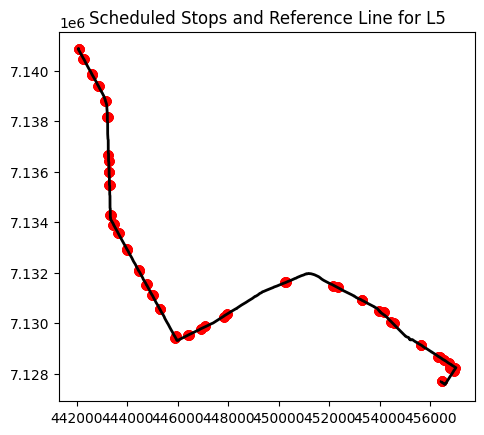

c:\Users\ocjh0850\Documents\METRAP\Bus GPS logs analysis\03_analysis\04_tool_development\python\utils.py:466: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  scheduled_trips_gdf['arrival_time'] = pd.to_datetime(scheduled_trips_gdf['arrival_time'])


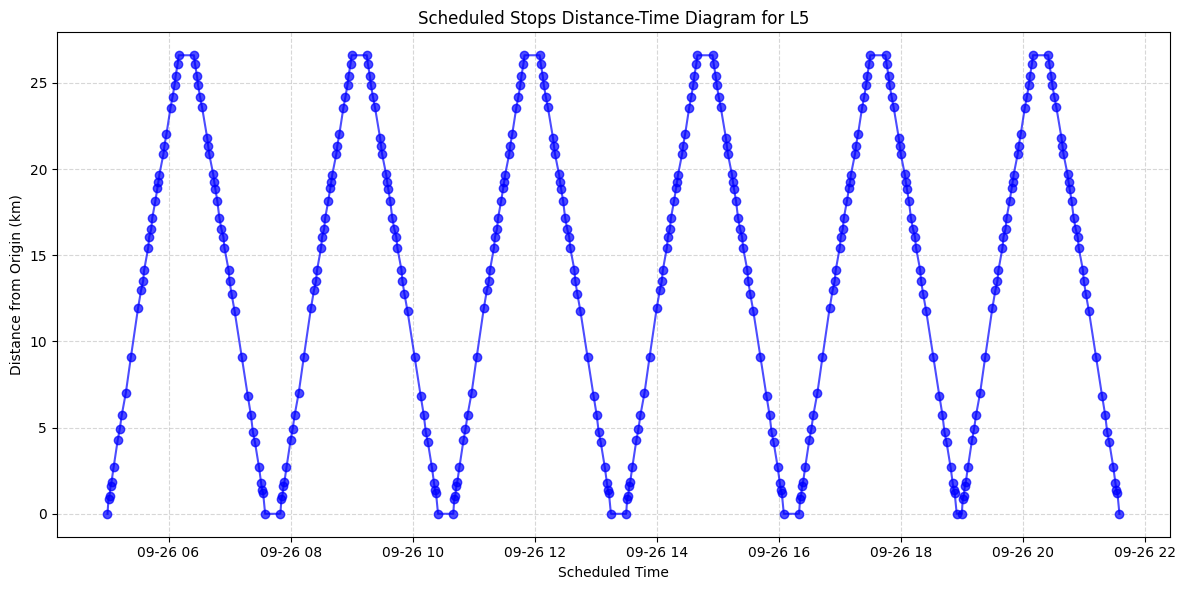

In [6]:
scheduled_trips_gdf, ref_line = utils.create_scheduled_trips_from_gtfs(
    route_ids=["47E", "47F"],
    gtfs_dir="./data/gtfs",
    lines_gdf=lines_gdf,
    line_id="L5",
    plot=True, 
    flip_origin=False
)

## 5. Comparative Analysis and Visualization

### 5.1 Visualize daily bus operation chart
Compare actual GPS data vs. scheduled operations

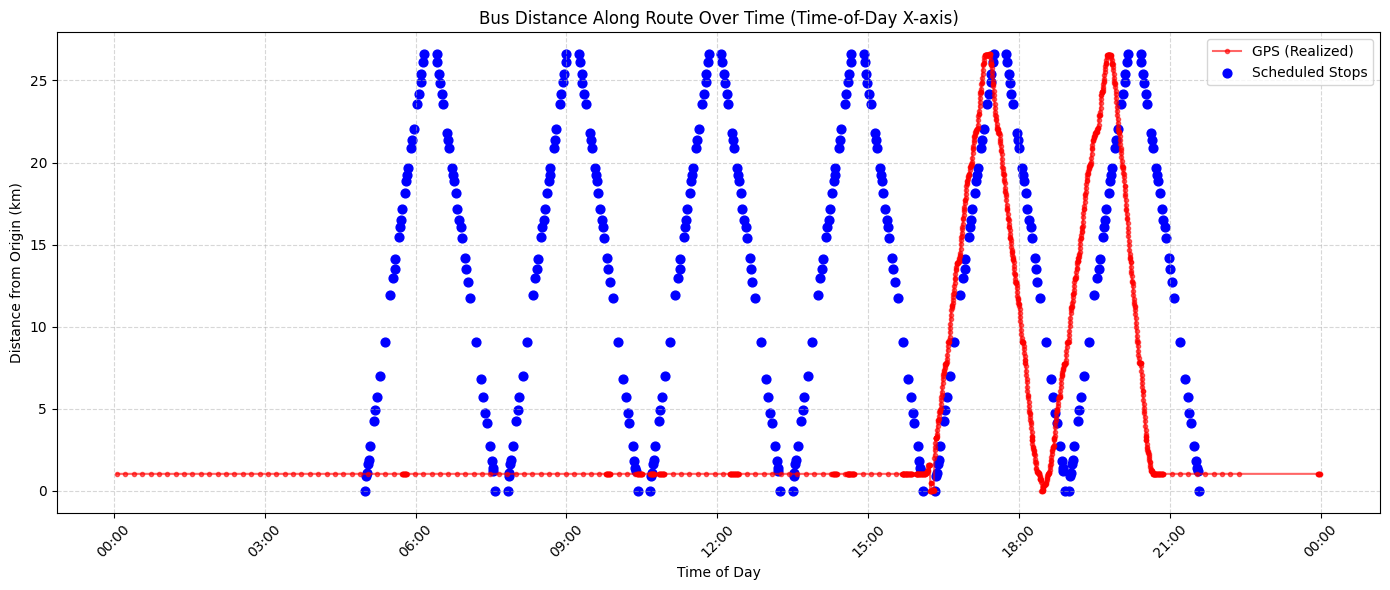

In [7]:
utils.plot_gps_vs_scheduled(gps_result_gdf, scheduled_trips_gdf,
                            gps_time_col="timestamp", sched_time_col="arrival_time")